# Import Modules

In [1]:
import glob
import os
import subprocess
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from PIL import Image

import pandas as pd
from functools import partial
from tqdm.notebook import trange, tqdm
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import timeit, random
import umap
import umap.plot

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import sys
sys.path.insert(0, os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE'))


from models import VanillaVAE


import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })

########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    if path in basepath:
        return basepath
    elif not os.path.exists(os.path.join(basepath, path)):
        os.makedirs(os.path.join(basepath, path))
        print('Added Directory:'+ os.path.join(basepath, path))
        return os.path.join(basepath, path)
    else:
        return os.path.join(basepath, path)

    
rootdir = os.path.expanduser('~/Research/FMEphys/')

# Set up partial functions for directory managing
join = partial(os.path.join,rootdir)
checkDir = partial(check_path,rootdir)
FigurePath = checkDir('Figures')


savefigs=False



In [3]:
AllExps = pd.read_csv(os.path.expanduser('~/Research/FMEphys/Completed_experiment_pool.csv'))

GoodExps = AllExps[(AllExps['Experiment outcome']=='good')].copy().reset_index()
GoodExps = pd.concat((GoodExps[(GoodExps['Computer']=='kraken')][['Experiment date','Animal name','Computer','Drive']],
                    GoodExps[(GoodExps['Computer']=='v2')][['Experiment date','Animal name','Computer','Drive']]))
GoodExps['Experiment date'] = pd.to_datetime(GoodExps['Experiment date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%2m%2d%2y')
GoodExps['Computer']=GoodExps['Computer'].str.capitalize()

In [7]:
WorldPath

'/home/seuss/Kraken/T/freely_moving_ephys/ephys_recordings/012621/EE8P6LT/fm1/*WORLDcalib.avi'

In [29]:
FolderNames = [] 
for n in range(len(GoodExps)):
    Comp=GoodExps['Computer'][n]
    Drive=GoodExps['Drive'][n]
    Date=GoodExps['Experiment date'][n]
    Ani=GoodExps['Animal name'][n]
    WorldPath = os.path.join(os.path.expanduser('~/'),Comp,Drive,'freely_moving_ephys/ephys_recordings',Date,Ani,'fm1','*WORLDcalib.avi')

    FM1Cam = glob.glob(WorldPath)

TrainSet = sorted([os.path.basename(x) for x in glob.glob(join('*WORLD'))])


In [35]:
SavePath = os.path.join(check_path(rootdir,os.path.basename(FM1Cam[0])[:-9]),'frame_%05d.png')
SavePath

'/home/seuss/Research/FMEphys/031021_EE11P13LTRN_control_Rig2_fm1_WORLD/frame_%05d.png'

In [33]:
len(TrainSet),TrainSet

(8,
 ['012221_G6H30P3LN_control_Rig2_fm1_WORLD',
  '020821_EE12P1RN_control_Rig2_fm1_WORLD',
  '021021_EE12P1RN_control_Rig2_fm1_WORLD',
  '021121_EE12P1RN_control_Rig2_fm1_WORLD',
  '021121_EE12P1RN_control_Rig2_fm2_WORLD',
  '021721_EE11P11LT_control_Rig2_fm2_WORLD',
  '022321_EE13P2RT_control_Rig2_fm1_WORLD',
  '031021_EE11P13LTRN_control_Rig2_fm1_WORLD'])

In [147]:
for n in range(len(GoodExps)):
    Comp=GoodExps['Computer'][n]
    Drive=GoodExps['Drive'][n]
    Date=GoodExps['Experiment date'][n]
    Ani=GoodExps['Animal name'][n]
    WorldPath = os.path.join(os.path.expanduser('~/'),Comp,Drive,'freely_moving_ephys/ephys_recordings',Date,Ani,'fm1','*WORLDcalib.avi')

    FM1Cam = glob.glob(WorldPath)
    if len(FM1Cam) > 0:
        SavePath = os.path.join(check_path(rootdir,os.path.basename(FM1Cam[0])[:-9]),'frame_%05d.png')
        subprocess.call(['ffmpeg', '-i', FM1Cam[0], '-vf','fps=10', SavePath])

In [221]:
print(WorldPath)
print('/home/seuss/Kraken/T/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/fm1')
print(FM1Cam[0])
print(SavePath)

/home/seuss/Kraken/T/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/fm1/*WORLDcalib.avi
/home/seuss/Kraken/T/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/fm1
/home/seuss/Kraken/T/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/fm1/012221_G6H30P3LN_control_Rig2_fm1_WORLDcalib.avi
/home/seuss/Research/FMEphys/012221_G6H30P3LN_control_Rig2_fm1_WORLD/frame_%05.png


# Make CSVs

In [ ]:


TrainSet = ['012821_EE8P6LT_control_Rig2_fm1_WORLD',
            '020821_EE12P1RN_control_Rig2_fm1_WORLD',
            '021021_EE12P1RN_control_Rig2_fm1_WORLD',
            '021121_EE12P1RN_control_Rig2_fm1_WORLD',
            '021721_EE11P11LT_control_Rig2_fm2_WORLD',
            '022321_EE13P2RT_control_Rig2_fm1_WORLD',]
ExpDir = []
DNum = []
for exp in TrainSet:
    DataPaths = sorted(glob.glob(join(exp,'*.png')))
    print(len(DataPaths))
    for n in range(len(DataPaths)):
        ExpDir.append(DataPaths[n].split('/')[-2])
        DNum.append(DataPaths[n].split('/')[-1])

df = pd.DataFrame({'BasePath':ExpDir,'FileName':DNum})

df.to_csv(join('WC_Train_Data.csv'))

print(len(df))
df['BasePath'].unique()

In [160]:
ValSet = ['021121_EE12P1RN_control_Rig2_fm2_WORLD']
ExpDir = []
DNum = []
for exp in ValSet:
    DataPaths = sorted(glob.glob(join(exp,'*.png')))
    for n in range(len(DataPaths)):
        ExpDir.append(DataPaths[n].split('/')[-2])
        DNum.append(DataPaths[n].split('/')[-1])

df = pd.DataFrame({'BasePath':ExpDir,'FileName':DNum})
df.to_csv(join('WC_Val_Data.csv'))

In [161]:
rootdir

'/home/seuss/Research/FMEphys/'

# Dataset 

In [ ]:
import torchvision.transforms.functional as F

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [2]:
from torchvision import transforms

def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
    
class WCDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.data_paths = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        

    def __len__(self):
        return(len(self.data_paths))
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,self.data_paths.iloc[idx,1],self.data_paths.iloc[idx,2])
        sample = pil_loader(img_name)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
size = (256,256)
composed = transforms.Compose([
#                                transforms.Resize(size),
                               transforms.RandomCrop(size),
                               transforms.Grayscale(num_output_channels=3),
#                                transforms.RandomResizedCrop(size),
#                                transforms.RandomHorizontalFlip(),
#                                transforms.RandomVerticalFlip(),
#                                transforms.ColorJitter(),
                               transforms.ToTensor()])

WC_dataset = WCDataset(csv_file=join('WC_Train_Data.csv'),root_dir=rootdir,transform=composed)

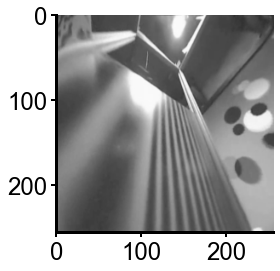

In [6]:
im = WC_dataset[np.random.randint(len(WC_dataset))]

plt.imshow(im.permute(1,2,0))

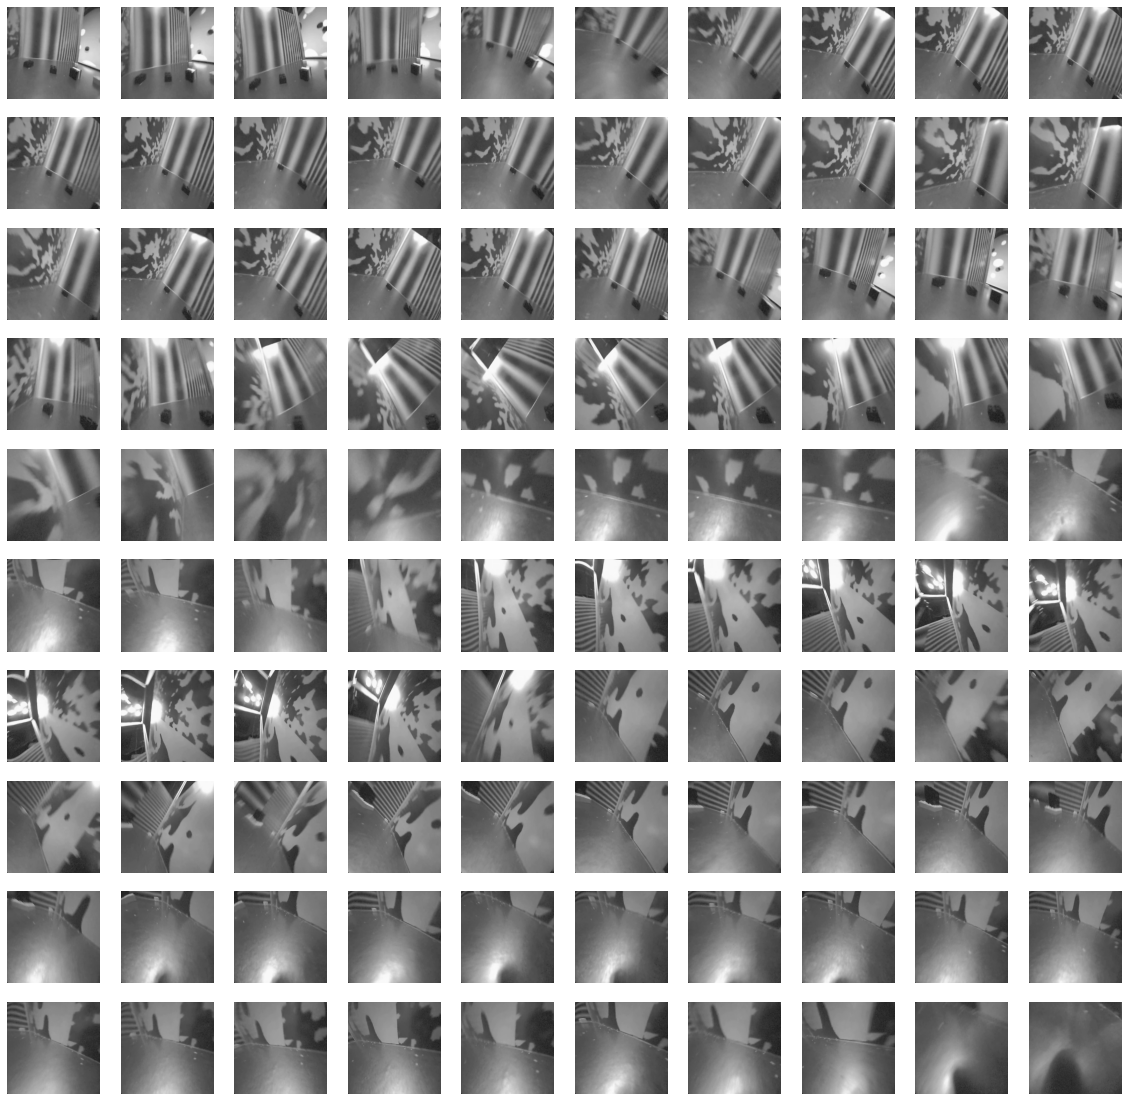

In [148]:
fig,axs = plt.subplots(10,10,figsize=(20,20))
axs=axs.flatten()
st = np.random.randint(len(WC_dataset))
for n in range(len(axs)):
    im = WC_dataset[st+n]
    axs[n].imshow(im.permute(1,2,0))
    axs[n].axis('off')

In [ ]:
im.to(device)

# Load Trained Network

In [2]:
from models.vanilla_vae import VanillaVAE
from experiment import VAEXperiment
import yaml
import torchvision

In [3]:
filename =  os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE','configs/WC_vae.yaml')
ckpt_path = glob.glob(os.path.expanduser('~/Research/FMEphys/logs/VanillaVAE/version_9/checkpoints/*.ckpt'))[0]
print(ckpt_path)
with open(filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
config

/home/seuss/Research/FMEphys/logs/VanillaVAE/version_9/checkpoints/epoch=499-step=80499.ckpt


{'model_params': {'name': 'VanillaVAE', 'in_channels': 3, 'latent_dim': 128},
 'exp_params': {'dataset': 'WorldCam',
  'data_path': '/home/seuss/Research/FMEphys/',
  'csv_path_train': '/home/seuss/Research/FMEphys/WC_Train_Data.csv',
  'csv_path_val': '/home/seuss/Research/FMEphys/WC_Val_Data.csv',
  'imgH_size': 64,
  'imgW_size': 64,
  'batch_size': 2048,
  'LR': 0.001,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.995},
 'trainer_params': {'gpus': 1, 'max_epochs': 500},
 'logging_params': {'save_dir': '/home/seuss/Research/FMEphys/logs/',
  'name': 'VanillaVAE',
  'manual_seed': 1265}}

In [4]:
model = VanillaVAE(**config['model_params'])
experiment = VAEXperiment(model,config['exp_params'])

experiment = experiment.load_from_checkpoint(ckpt_path,vae_model=model,params=config['exp_params'],map_location=torch.device('cuda'))
experiment.to(device)

val_dataloader = experiment.val_dataloader()

train_dataloader = experiment.train_dataloader()

In [5]:
zt = []
recont = []
# real_img = []
for batch in tqdm(train_dataloader):   
    z,recon,_,mu,log_var = model.grab_latents(batch.to(device))
    zt.append(z.cpu().detach().numpy())
    recont.append(recon.cpu().detach().numpy())
zt = np.vstack(zt)
recont = np.stack(recont)
# real_img = np.stack(real_img)

  0%|          | 0/161 [00:00<?, ?it/s]

In [6]:
batch = next(iter(train_dataloader))

In [11]:
z,recon,_,mu,log_var = model.grab_latents(batch.to(device))

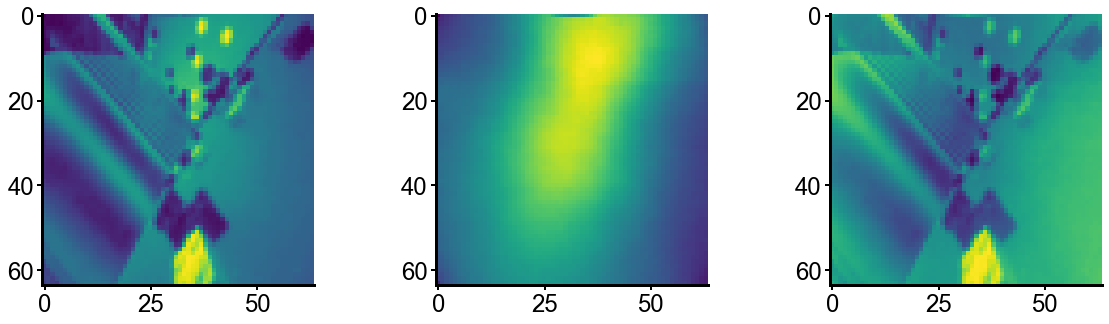

In [71]:
n=2

b1 = batch.cpu()[n].detach().numpy().transpose(1,2,0)
b1 = (b1-b1.min())/(b1.max()-b1.min())
r1 = recon.cpu()[n].detach().numpy().transpose(1,2,0)
r1 = (r1-r1.min())/(r1.max()-r1.min())
temp = (b1-r1)
# temp = (temp-temp.min())/(temp.max()-temp.min())

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].imshow(b1[:,:,0])
axs[1].imshow(r1[:,:,0])
axs[2].imshow(temp[:,:,0])

In [17]:
torch.mean((batch.cuda()[0]-recon.cuda()[0])**2)

tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>)

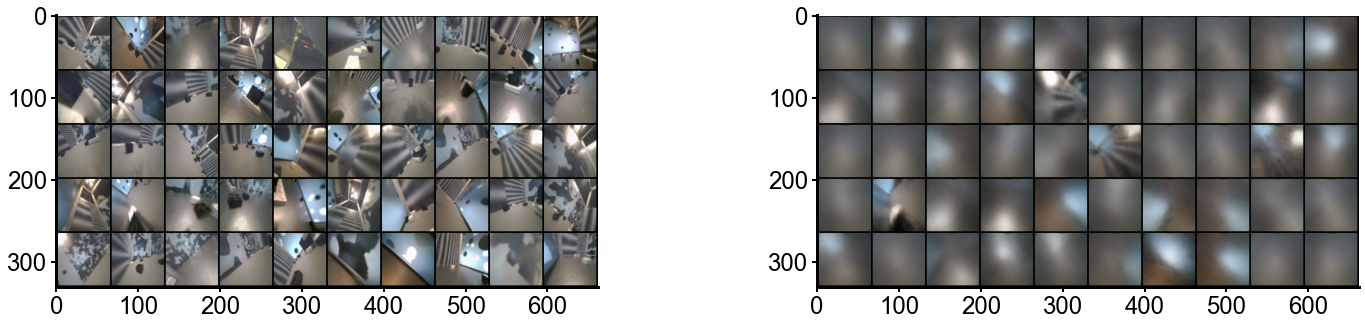

In [63]:
t=50
fig, axs = plt.subplots(1,2,figsize=(25,5))
im_grid = torchvision.utils.make_grid(batch.cpu()[t:t+50],nrow=10,normalize=True)


axs[0].imshow(im_grid.permute(1,2,0))


im_grid2 = torchvision.utils.make_grid(recon.cpu()[t:t+50],nrow=10,normalize=True)

axs[1].imshow(im_grid2.permute(1,2,0))

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(zt)


In [21]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    plt.sca(last_axes)
    return cbar

cmap = discrete_cmap(embedding.shape[0],base_cmap=plt.cm.jet)


In [50]:
zt[::100].shape

(3298, 128)

In [51]:
mapper = reducer.fit(zt[::100])

<AxesSubplot:>

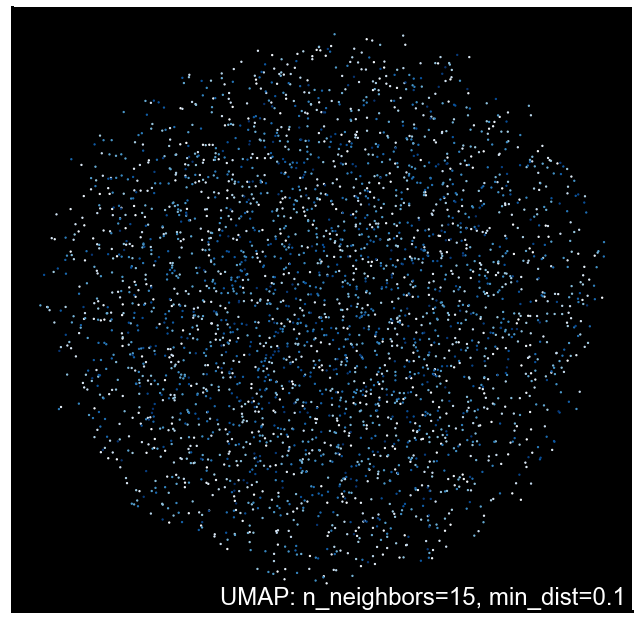

In [52]:
umap.plot.points(mapper, values=np.arange(zt[::100].shape[0]), color_key_cmap='Paired', background='black')


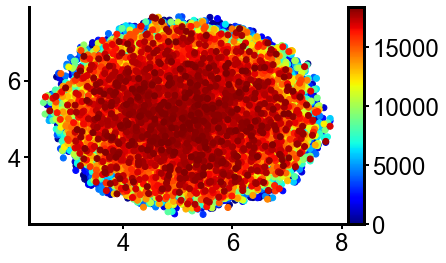

In [22]:
p1 = plt.scatter(embedding[:,0],embedding[:,1],c=range(embedding.shape[0]),cmap=cmap)
cb = add_colorbar(p1)


In [8]:
Batch = next(iter(val_dataloader))

In [9]:
real_img=Batch
recon,_,mu,log_var = experiment(real_img)

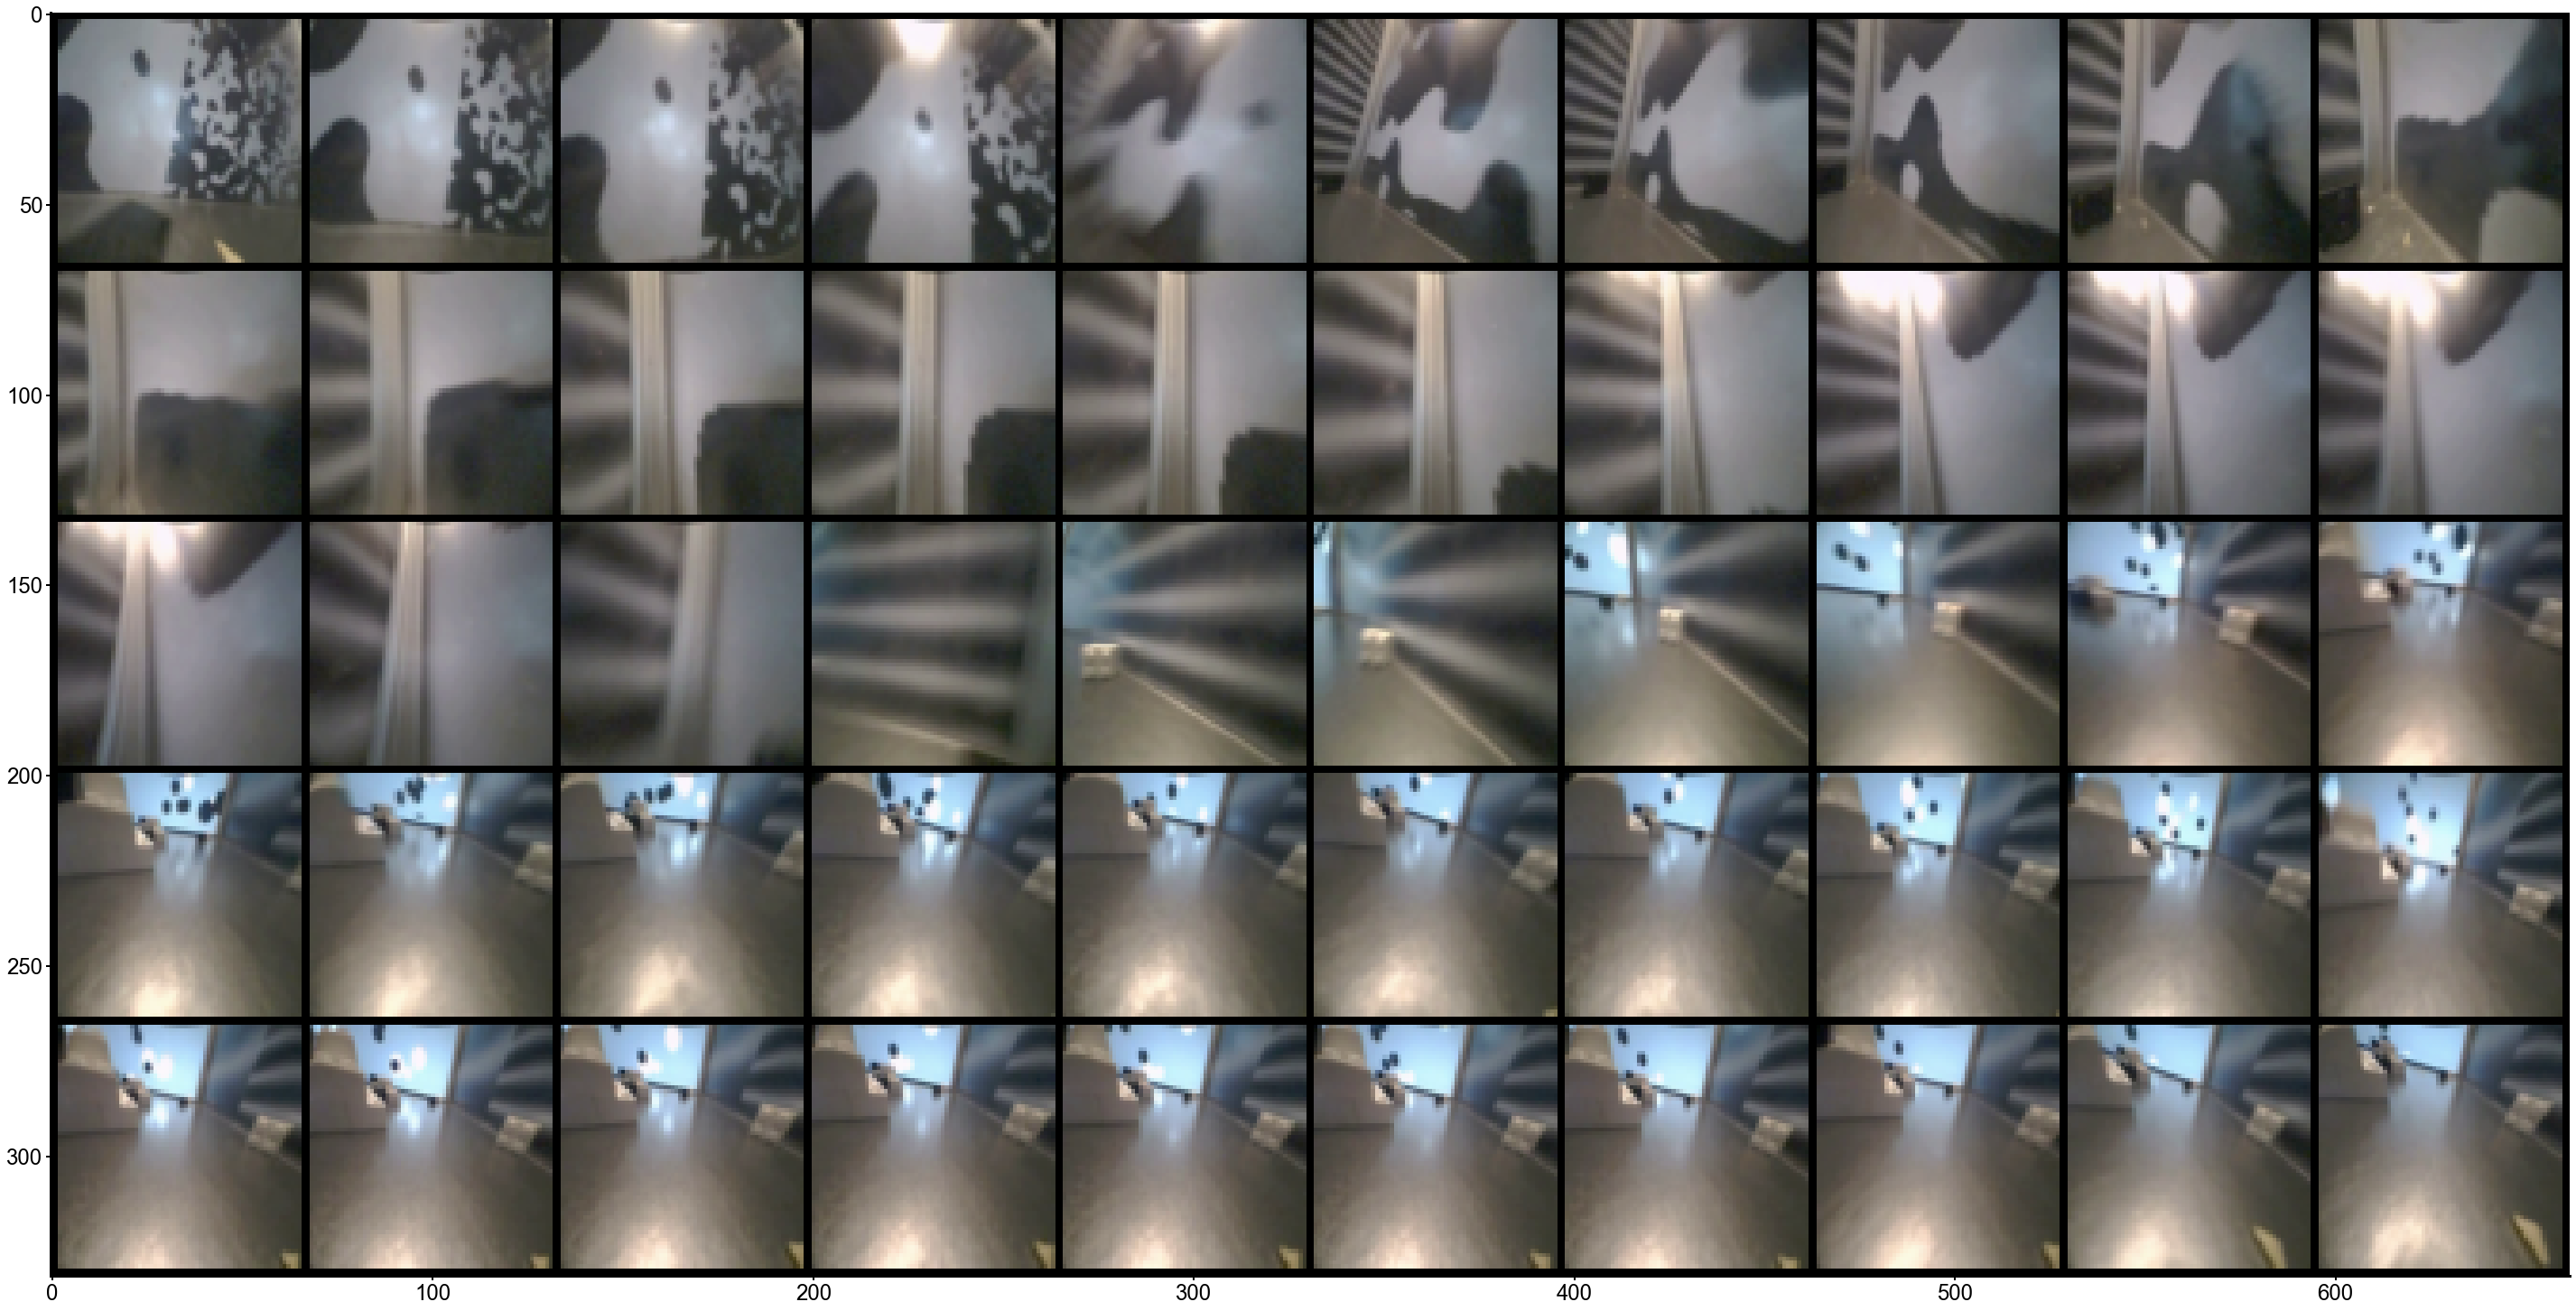

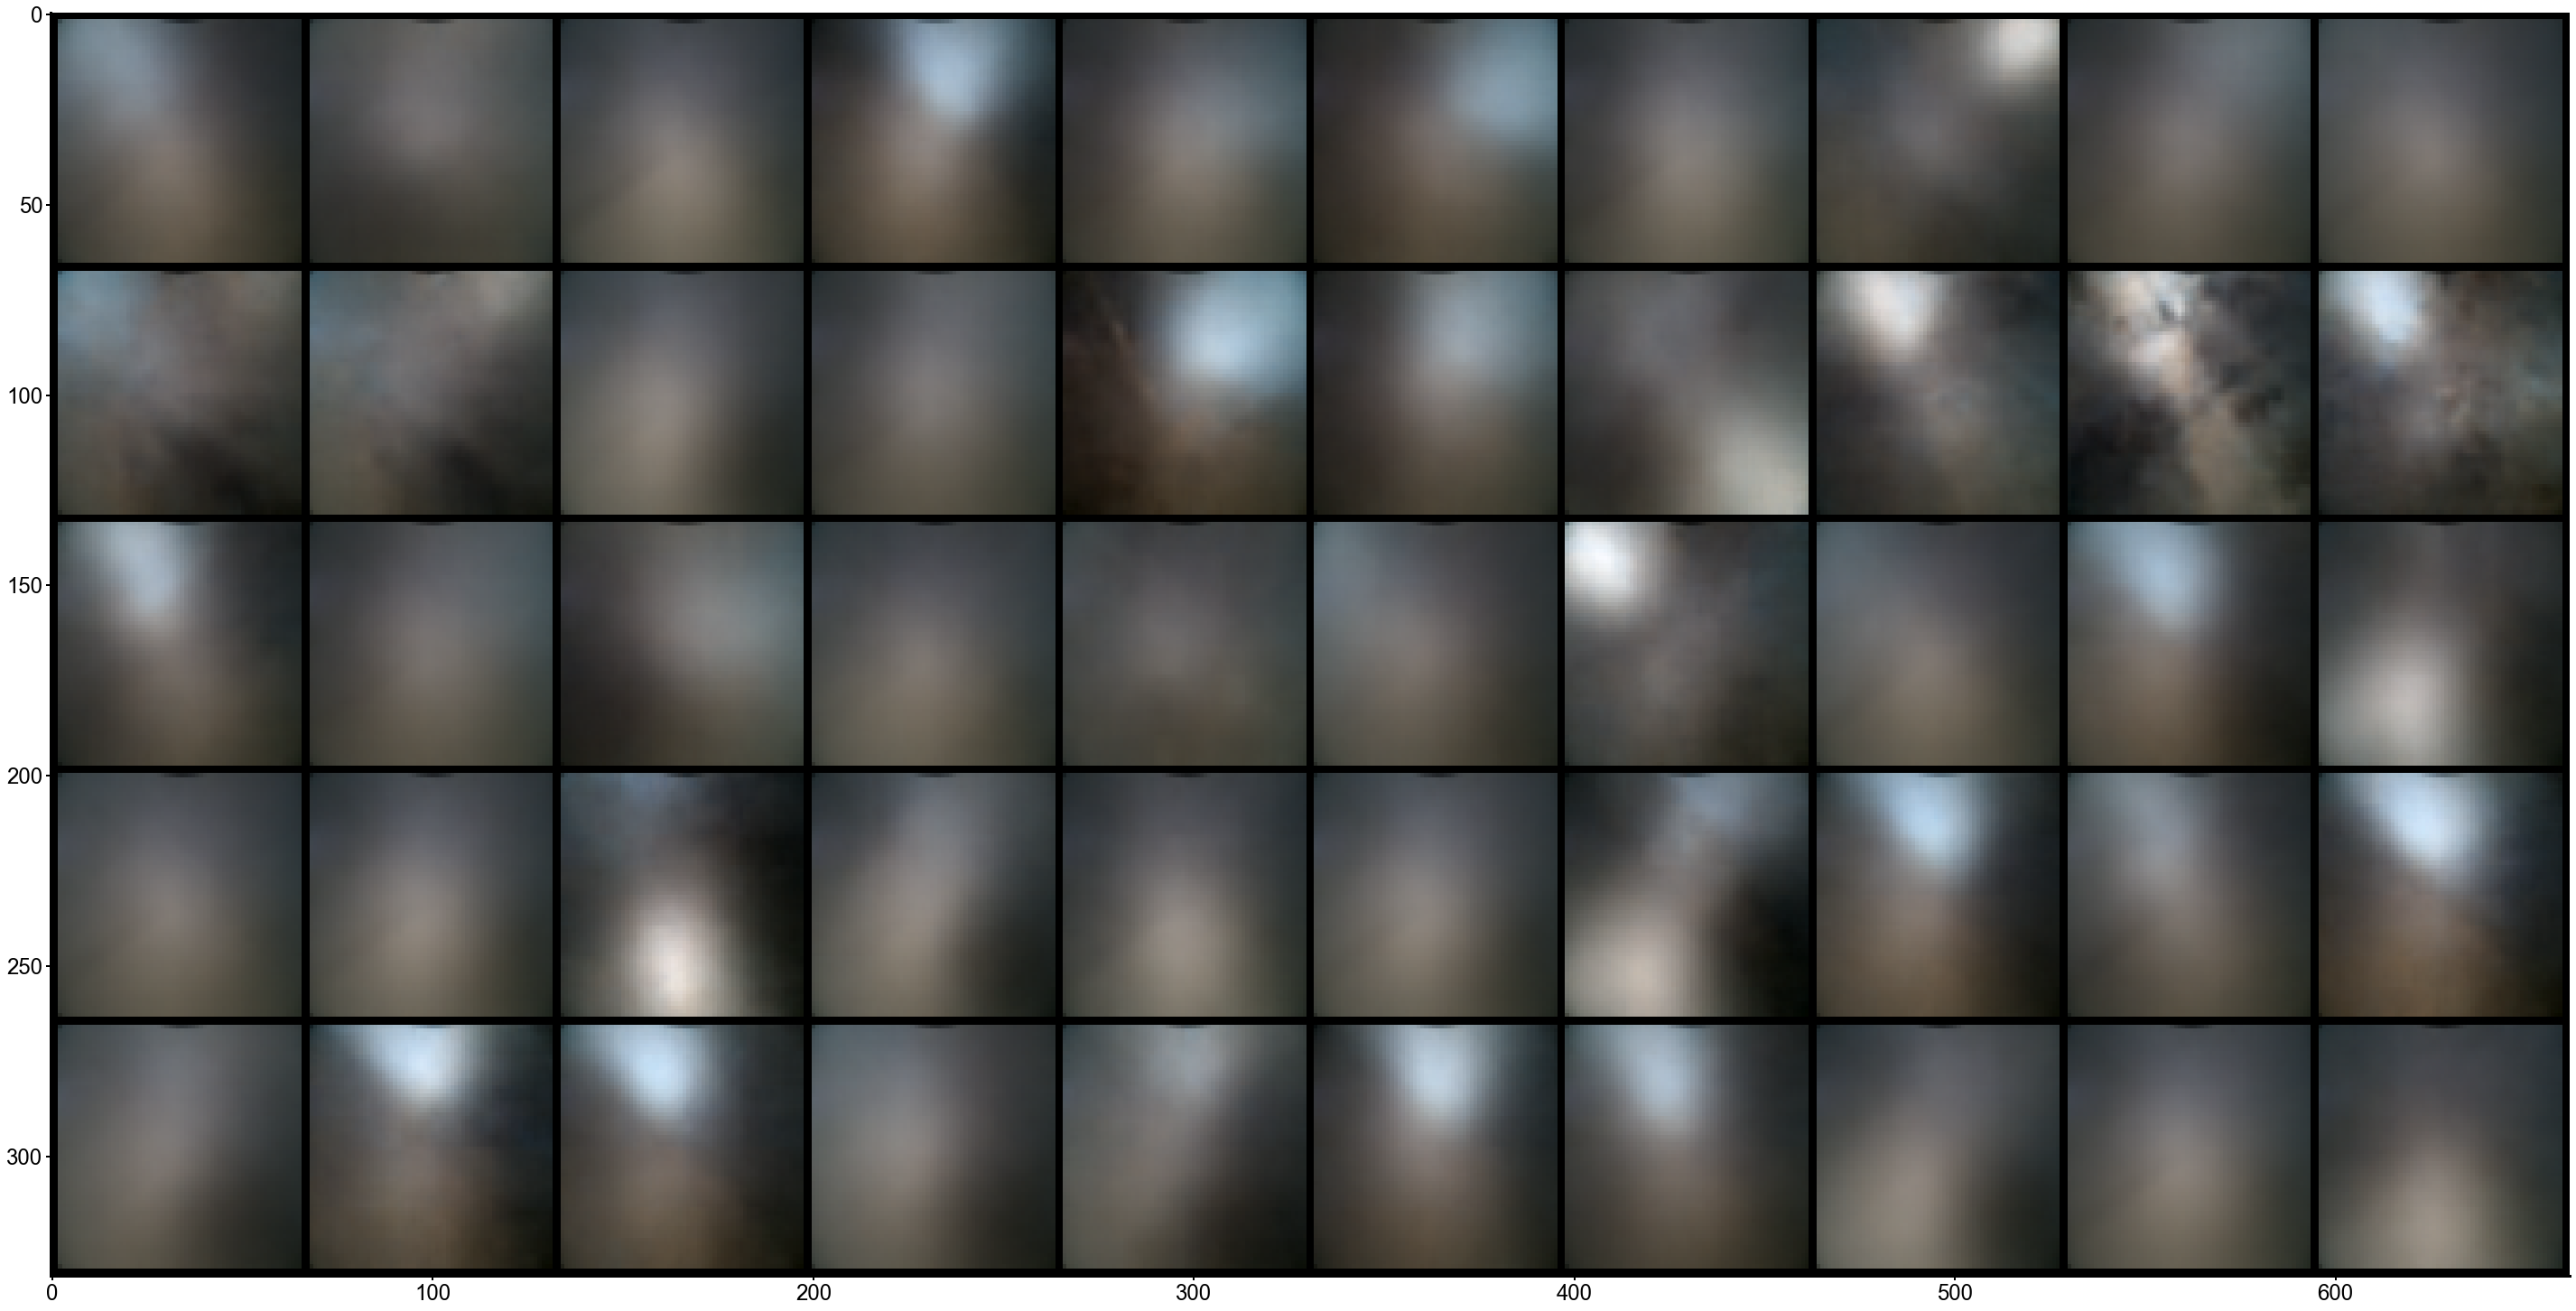

In [22]:
t = 300
im_grid = torchvision.utils.make_grid(real_img[t:t+50],nrow=10,normalize=True)

plt.figure(figsize=(50,30))
plt.imshow(im_grid.permute(1,2,0))

im_grid2 = torchvision.utils.make_grid(recon[t:t+50],nrow=10,normalize=True)

plt.figure(figsize=(50,30))
plt.imshow(im_grid2.permute(1,2,0))